In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5


In [4]:
f(3.0)

20.0

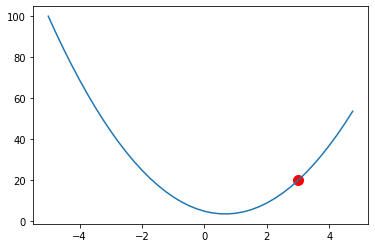

In [20]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.scatter([3.0], [f(3.0)], c='r', s=100);

In [21]:
h = 0.0001
x = -3.0

(f(x + h) - f(x)) / h

-21.999700000066014

In [23]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)


4.0


In [26]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
a += h
d2 = a*b +c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h )


d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [76]:
from typing import Callable, Optional, Tuple, Union
from __future__ import annotations


class Value:
    def __init__(self, data: Union[int, float], _children: tuple[Value, ...] = (), _op: str = "", label: str = "") -> None:
        self.data = data
        self.grad: float = 0.0
        self._prev = set(_children)
        self._op = _op
        self._backward: Callable[[], Union[Value, None]] = lambda: None
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def __pow__(self, other: Union[int, float]):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
            out._backward = _backward

            return out

    def __neg__(self):  # -self
        return self * -1

    def __radd__(self, other):  # other + self
        return self + other

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __rtruediv__(self, other):  # other / self
        return other * self**-1
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), "ReLU")

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


In [77]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

L


Value(data=-8.0)

In [78]:
from graphviz import Digraph


def trace(root):
    nodes: set[Value] = set()
    edges: set[tuple[Value, Value]] = set()

    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root: Value):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data  %.2f | grad %.2f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


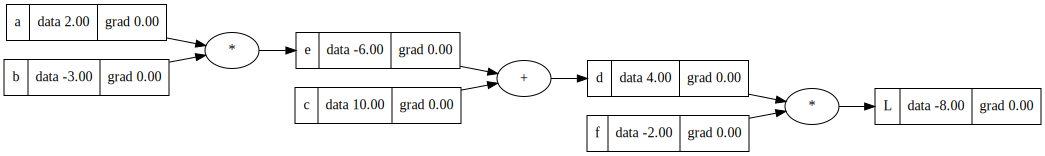

In [79]:
draw_dot(L)

In [ ]:
def lol() -> float:
    h = 0.0001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L2 = L.data

    return (L2-L1)/h